# Results Analysis

## Imports

In [1]:
!pip install -q pandas seaborn


[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

## Definitions

### Constants

In [3]:
RESULT_DIR  = '../results/'

In [4]:
RESULT_FILES = !find $RESULT_DIR -type f 

#### Strategies

In [5]:
CLASSIC = {'random_sampling', 'margin_sampling', 'training_utility_sampling', 'density_weighted_sampling', 'expected_error_reduction'}
NEIGHBORHOOD = {'borderline_points_sampling', 'k_disagreeing_neighbors_sampling', 'local_set_cardinality_sampling',
                'ls_radius_sampling', 'intra_extra_ratio_sampling', 'harmfulness_sampling', 'usefulness_sampling'}
LIKELIHOOD = {'class_likelihood_sampling', 'class_likeliood_diff_sampling'}
FEATURE_BASED = {'f1_sampling', 'f2_sampling', 'f3_sampling', 'f4_sampling'}
TREE_BASED = {'disjunct_class_percentage_sampling', 'disjunct_size_sampling', 'tree_depth_pruned_sampling',
              'tree_depth_unpruned_sampling'}
CLASS_BALANCE = {'class_balance_sampling', 'minority_value_sampling'}

### Helper Functions

In [6]:
def sort_curves(x: pd.Index):
    return x.map(lambda y: (not y in CLASSIC,
                            not y in NEIGHBORHOOD,
                            not y in LIKELIHOOD,
                            not y in FEATURE_BASED,
                            not y in TREE_BASED,
                            y))

In [7]:
def get_style(method):
    if method == 'random_sampling':
        return '--'
    elif method in CLASSIC:
        return '-'
    elif method in NEIGHBORHOOD:
        return '^-.'
    elif method in LIKELIHOOD:
        return 's-.'
    elif method in FEATURE_BASED:
        return '*-.'
    elif method in TREE_BASED:
        return 'h-.'
    else:
        return 'd-.'

In [8]:
def show_counts(df, model, ax):
    df = df.loc[:,model,:]
    df.reset_index().strategy.value_counts().sort_index(ascending=False).plot(
        ax=ax, kind='barh', grid=True, title=model, xlim=(0,100), xticks=range(0, 101, 10),
        sharey=True, figsize=(16,8), xlabel='Experiments count')

### Learning Curves

In [9]:
def plot_learning_curves(df, dataset, classifier):
    color_list = sns.color_palette(n_colors=len(df.columns))
    
    local_df = df.loc[(dataset, classifier)].sort_index(key=sort_curves).T
    
    for i, column in enumerate(local_df.columns):
        # Aplica média móvel
        scores = local_df[column].rolling(window=5).mean()
        plt.plot(local_df.index + 1,
                 scores,
                 get_style(column),
                 color=color_list[i],
                 label=column,
                 markevery=10)

    
    # Ordenação de legenda
    plt.legend(ncol=2)
    
    # Configuração da imagem
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    plt.grid()
   
    # Titulo
    plt.title(dataset)
    plt.xlabel('Query')
    plt.ylabel('f1-score (macro)')

    

In [10]:
def show_all_learning_curves(df, model):

    for dataset in df.index.levels[0]:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', Warning)
        plot_learning_curves(df, dataset=str(dataset), classifier=model)    

        display(plt.gcf())
        
        if input() == 'q':
            break

        clear_output(wait=True)
        plt.close()
    plt.close()

### Ranking Curves

In [11]:
def plot_ranking_curves(data: pd.DataFrame, model:str, group_strategies=False):

    ranked_df = df.loc[:, model, :].groupby('dataset').rank(ascending=False)
    
    mean_rank_df = ranked_df.groupby('strategy').mean().sort_index(key=sort_curves).T

    color_list = sns.color_palette(n_colors=len(mean_rank_df.columns))
    
    for i, column in enumerate(mean_rank_df.columns):
        # Aplica média móvel
        scores = mean_rank_df[column].rolling(window=5, min_periods=1).mean()

        plt.plot(mean_rank_df.index + 1,
                 scores,
                 get_style(column),
                 color=color_list[i],
                 label=column,
                 linewidth=0.7,
                 markevery=(0.3, 0.2))


    plt.gca().invert_yaxis()
    
    # Ordenação de legenda
    plt.legend(bbox_to_anchor=(1.01,1), ncol=1, shadow=True)

    # Grid
    plt.grid()
    
    # Configuração da imagem
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    
   
    # Titulo
    plt.title(f'Ranking Curves ({model})')
    plt.xlabel('Query')
    plt.ylabel('Avg. Rank')

# plot_ranking_curves(df, 'SVC')

In [12]:
def plot_ranks_with_bands(df, model=None):
    
    ranked_df = df.groupby('dataset').rank(ascending=False).groupby(['model','strategy']).mean()

    ranked_df_smoothed = ranked_df.rolling(window=5, axis='columns', min_periods=1).mean().sort_index(key=sort_curves)

    auc_series = df.groupby(['model', 'strategy']).mean().apply(np.trapz, axis='columns')

    # Plot Bands
    for model_name, df in ranked_df_smoothed.groupby('model'):
        plt.fill_between(np.arange(df.shape[1]), df.max(), df.min(),
                         alpha=0.1, label=model_name)

    plt.title(model)
    if model is None:
    # Plot Best Strategy for each model
        for model, df in ranked_df_smoothed.groupby('model'):
            best_strategy = auc_series.loc[model].idxmax()
            
            plt.plot(ranked_df_smoothed.loc[model, best_strategy],
                     get_style(best_strategy),
                     label=' + '.join([model,best_strategy]),
                     markevery=(50,50),
                     linewidth=0.8)
            
            # worst_strategy = auc_series.loc[model].idxmin()
            # plt.plot(ranked_df_smoothed.loc[model, worst_strategy],
            #          get_style(best_strategy),
            #          label=' + '.join([model,worst_strategy]),
            #          markevery=(50,50),
            #          linewidth=0.8)
    else:
        
        color_list = sns.color_palette(n_colors=len(ranked_df_smoothed.columns))

        for i, (strategy, row) in  enumerate(ranked_df_smoothed.loc[model].iterrows()):
            plt.plot(ranked_df_smoothed.loc[model, strategy],
                     get_style(strategy),
                     label=strategy,
                     color=color_list[i],
                     markevery=(0.3, 0.2),
                     linewidth=0.8)
        

    plt.xticks(range(0, 100, 10))
    plt.grid()
    plt.xlabel('Queries')
    plt.ylabel('Mean Ranking Position')
    plt.legend(bbox_to_anchor=(1.04,1), ncol=1)
    plt.gca().invert_yaxis()
    
    # Configuração da imagem
    fig = plt.gcf()
    fig.set_size_inches(10, 8)

## Data Gathering

In [13]:
data = {
    os.path.splitext(os.path.basename(f))[0]: pd.read_csv(f, index_col=0).mean(axis='columns')
    for f in RESULT_FILES
}

In [14]:
index_columns = ['dataset', 'model', 'strategy']

In [15]:
df = pd.DataFrame(data).T.reset_index(names='file_name')
df[index_columns] = df.file_name.str.split('#', expand=True)
df = df.set_index(index_columns).drop(columns='file_name')

Remove observações para EER, pois só foram feitas para SVM:

## Data Analysis

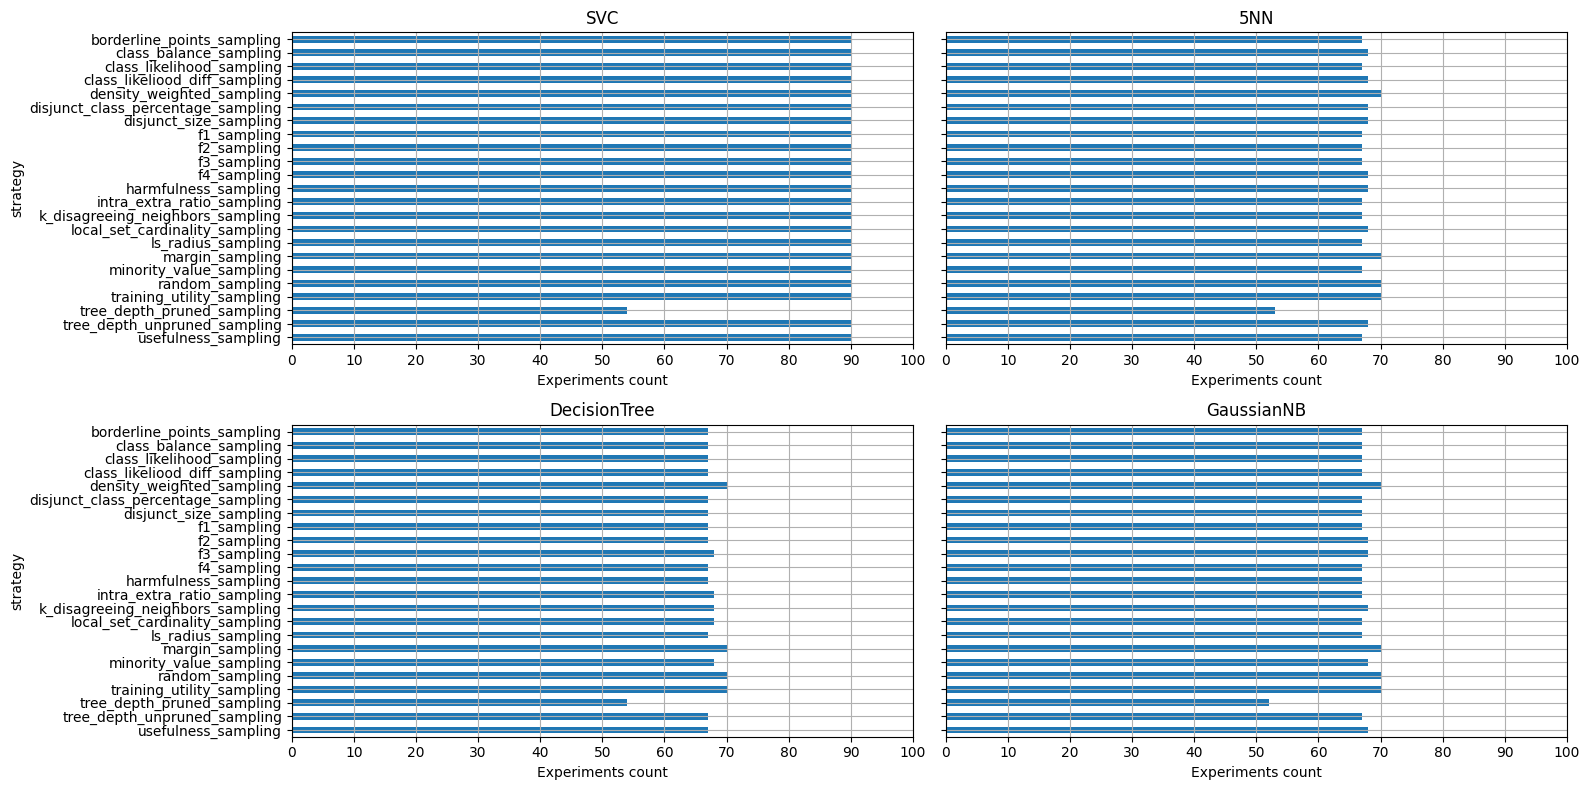

In [22]:
fig, axs = plt.subplots(2,2)

show_counts(df, ax=axs[0, 0], model='SVC')
show_counts(df, ax=axs[0, 1], model='5NN')
show_counts(df, ax=axs[1, 0], model='DecisionTree')
show_counts(df, ax=axs[1, 1], model='GaussianNB')

fig.tight_layout()

## Ranking Curves

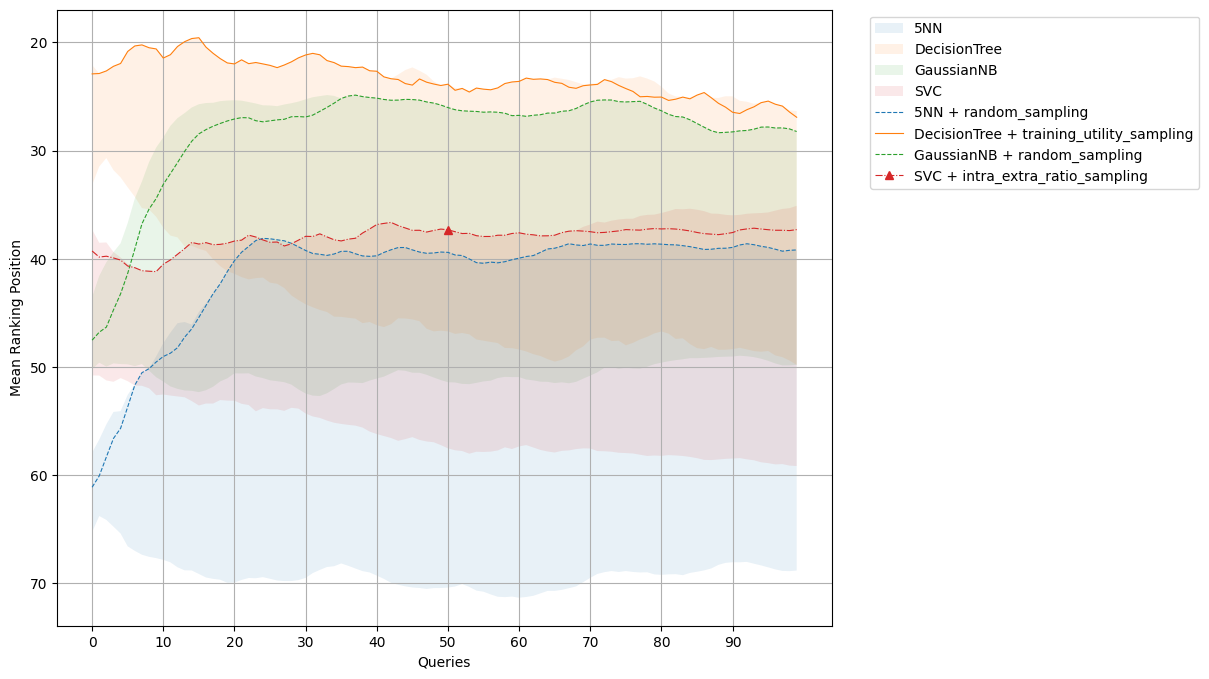

In [19]:
plot_ranks_with_bands(df)

### SVC

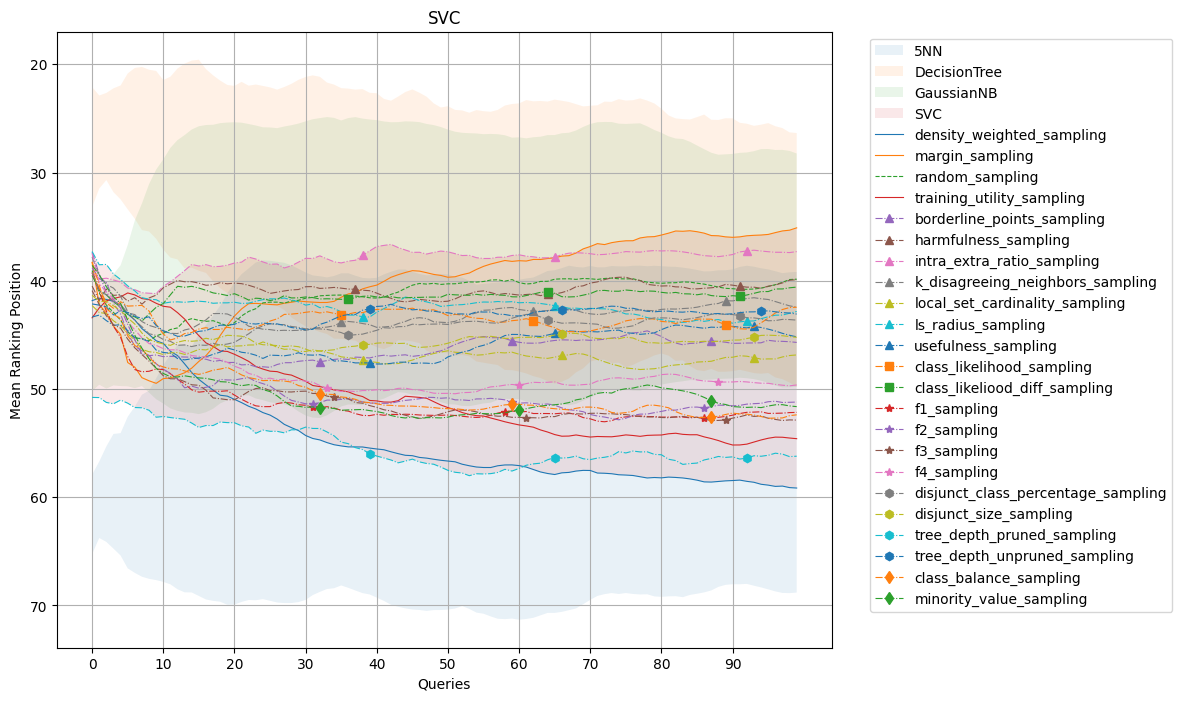

In [20]:
plot_ranks_with_bands(df, model='SVC')

### KNN

In [ ]:
plot_ranks_with_bands(df, model='5NN')

### Decision Tree

In [ ]:
plot_ranks_with_bands(df, model='Decision Tree')

### Gaussian NB

In [ ]:
plot_ranks_with_bands(df, model='Gaussian Naive Bayes')

In [ ]:
def process_line(line):
    columns = line.split(' - ')
    if len(columns) == 4:
        return columns[:1] + [None] + columns[1:]
    elif len(columns) == 5:
        return columns
    else:
        print(line)
        raise ValueError('Número de colunas incompatível.')
        
    

In [ ]:
def create_log_df(log_file):
    print(log_file)
    log_lines = !cat $log_file    
    columns = ['time', 'process','context', 'type', 'msg']
    processed_lines = (process_line(line) for line in log_lines)
    log_df = pd.DataFrame(processed_lines, columns=columns)
    log_df[['dataset', 'model', 'strategy']]= log_df.context.map(lambda x: x[1:-1]).str.split(',', expand=True)
    log_df.drop(columns='context', inplace=True)
    
    return log_df

In [ ]:
def plot_fall_backs(log_df):
    rows = []
    fall_backs_df = log_df[log_df.msg.str.contains('Falling back')]
    
    for v in fall_backs_df.model.unique():
        row = fall_backs_df[fall_backs_df.model == v].strategy.value_counts()
        row.rename(v, inplace=True)
        rows.append(row)

    N_SPLITS = 5
    N_DATASETS = 90
    N_QUERIES = 100
    pd.concat(rows, axis=1).plot(kind='barh', grid=True, xlim = (0,N_DATASETS*N_SPLITS*N_QUERIES))
    plt.legend(bbox_to_anchor=(1.01, 1))
    

In [ ]:
LOG_FILES = !ls  ../experiments/*.log*

In [ ]:
log_df = pd.concat(create_log_df(f) for f in LOG_FILES)

In [ ]:
log_df.drop_duplicates(inplace=True)

In [ ]:
log_df

In [ ]:
plot_fall_backs(log_df)

In [ ]:
log_df[log_df.type == 'WARNING'][['msg', 'model']].to_csv('fallback.csv')

In [ ]:
for model in log_df.model.unique():
    print(model, log_df.loc[(log_df.model.str.contains(model)) &
    (log_df.msg.str.contains('finalizado')) &
    (~log_df.strategy.str.contains('expected'))].shape[0])

In [ ]:
log_df